<a href="https://colab.research.google.com/github/Ellie-117/Bitcoin_Price/blob/main/AML_Project_013_Group13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic: Predicting Bitcoin Price

## Introduction



Bitcoin is a decentralized electronic exchange system and represents a major change in the global financial system. Its system is based on peer-to-peer and cryptographic protocols and is not managed by any government or bank (Vidal 2014). It operates on the basis of a collusive and uncertain system in which all transactions are placed in an open ledger called blockchain (Guo and Liang 2016). 

Today, Bitcoin has become one of the most favorable investment options. It is a fresh market that is still in its transition phase, therefore, a lot of fluctuations can still be observed. However, even though the price easily fluctuates, many people still believe they can earn huge profits by investing in Bitcoin. While considerable research has been done concerning Bitcoin network analysis, limited research has been conducted on predicting the Bitcoin price. 

In this project, we attempt to forcast the future bitcoin price with time-series model. Besides the past five-year bitcoin price data, we have collected other datasets including blockchain price, Ethereum price and so on to work as exogenous features incresing the accuracy of the model. To get a reliable and effective prediction result, we built several models with different methodologies including ARIMA, XGBoost and LSTM. The results show that the LSTM has the best performance among the models who get the least mean square error when evaluating.

## Dataset & Preprocessing


To choose which features could possibly be useful for predicting Bitcoin price, we decided to include several factors: the previous price of Bitcoin(BTC), some other popular crypto coins such as Ethereum coin(ETH) and Binance coin(BNB), USD price, a blockchain company(Riot Blockchain), tweets, a cryptocurrency company(Coinbase). The datasets include each day’s 'Open', 'High', 'Low', 'Close', 'Adj Close', and 'Volume'. Next step is to fill in the missing values. Since the cryptocurrency market doesn't have breaks during weekends or holidays, we only need to fill the missing values for USD price using the backfilling method. To calculate scores for each tweet, we firstly clean the data to read one by one and process them. Then using the sentiment intensity analyzer to get sentiment scores and store tweets with polarity scores in a dictionary.
 
Based on the datasets we get for BTC, ETH, BNB, USD, Blockchain, Coinbase, we only need their "Adjusted close" column, so we subtracted that column from each of the datasets. Due to the different start time of coins, we used inner join to merge the columns from BTC, ETH, BNB, USD, and Blockchain. However, since coinbase and tweets only started last year, we decided to only use left join for their data and leave the rest as null. The columns in the dataset are: 'Date', 'bnb', 'eth', 'btc', 'usd', 'blockchain', 'tweets', 'cb'. Eventually, the time range of the dataset is from 2017-11-09 to 2022-12-01.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import time
import math

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import brier_score_loss
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve, CalibrationDisplay
#!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
from pandas.core.frame import DataFrame
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,activations
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import SARIMAX
#!pip install pmdarima   #if pmdarima is not installed, run this code and restart runtime
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.varmax import VARMAX

import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Filling the nulls in USD

usd_day=pd.read_csv('USD_unfill.csv')
usd_day.set_index(pd.to_datetime(usd_day["Date"]), inplace=True)
idx = pd.date_range('2017-11-09', '2022-12-01')
usd_day = usd_day.reindex(idx, fill_value= None)
usd_day = usd_day.drop(columns=['Date'])

usd_day.fillna(method='bfill',inplace=True)
usd_day.reset_index(inplace=True)
usd_day = usd_day.rename(columns = {'index':'Date'})

usd_day.to_csv('USD.csv')

In [ ]:
#calculate tweets' sentiment score
datafile =("/content/drive/MyDrive/Colab Notebooks/Copy of Bitcoin_tweets.csv")
df = pd.read_csv(datafile, header=0, skiprows=lambda i: i % 3 != 0)
df_raw = df.copy()
df= df.dropna(subset=['text']).reset_index(drop=True)
df["source"]= df["source"].apply(str)
df["source"]= df["source"].str.lower()
df_cleaned = df[~df["source"].str.contains("bot")]
btc=df_cleaned.loc[:,["date","text","user_location","user_description","user_followers","user_friends"]]
btc["text"] = btc["text"].apply(str)
tweets = btc["text"].tolist()
def processTweet(tweet):
    # process the tweets
    #Convert to lower case
    tweet = tweet.lower()
    #Convert www.* or https?://* to URL
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL',tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','AT_USER',tweet)
    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    #Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)#trim
    tweet = tweet.strip('\'"')
    return tweet
tweets_cleaned = []
#Read the tweets one by one and process it
for i in range (0,len(tweets)):
    processedTweet = processTweet(tweets[i])
    tweets_cleaned.append(processedTweet)
vader = SentimentIntensityAnalyzer()
def getCoumpoundScore(Tweets):
    score = vader.polarity_scores(Tweets)['compound']
    return score
scores = []

#Read the tweets one by one and get the sentiment score
for i in range (0,len(tweets_cleaned)):
    tweets_score = getCoumpoundScore(tweets_cleaned[i])
    scores.append(tweets_score)   

#store the tweet with polarity score in a dictionary
df ={"tweets": tweets_cleaned, "score" : scores}
data = DataFrame(df)

In [ ]:
# BNB, BTC, ETH, USD, blockchain, tweets, Coinbase

bnb = pd.read_csv('BNB.csv')
bnb_short = bnb[['Date', 'Adj Close']]
bnb_short = bnb_short.rename(columns={'Adj Close': 'bnb'})

btc = pd.read_csv('BTC.csv')
btc_short = btc[['Date', 'Adj Close']]
btc_short = btc_short.rename(columns={'Adj Close': 'btc'})

eth = pd.read_csv('ETH.csv')
eth_short = eth[['Date', 'Adj Close']]
eth_short = eth_short.rename(columns={'Adj Close': 'eth'})

usd = pd.read_csv('USD.csv')
usd_short = usd[['Date', 'Adj Close']]
usd_short = usd_short.rename(columns={'Adj Close': 'usd'})

blockchain = pd.read_csv('blockchain.csv')
blockchain_short = blockchain[['Date', 'Adj Close']]
blockchain_short = blockchain_short.rename(columns={'Adj Close': 'blockchain'})

tweets = pd.read_csv('tweets.csv')
tweets_short = tweets[['Date', 'score']]
tweets_short = tweets_short.rename(columns={'score': 'tweets'})

cb = pd.read_csv('COINBASE.csv')
cb_short = cb[['Date', 'Adj Close']]
cb_short = cb_short.rename(columns={'Adj Close': 'cb'})

# Joining the columns

bnb_eth = pd.merge(left=bnb_short, right=eth_short, left_on='Date', right_on='Date')
bnb_eth_btc = pd.merge(left=bnb_eth, right=btc_short, left_on='Date', right_on='Date')
bnb_eth_btc_usd = pd.merge(left=bnb_eth_btc, right=usd_short, left_on='Date', right_on='Date')
bnb_eth_btc_usd_chain = pd.merge(left=bnb_eth_btc_usd, right=blockchain_short, left_on='Date', right_on='Date')
bnb_eth_btc_usd_chain_tweets = bnb_eth_btc_usd_chain.merge(tweets_short, on='Date', how='left')
bnb_eth_btc_usd_chain_tweets_cb = bnb_eth_btc_usd_chain_tweets.merge(cb_short, on='Date', how='left')

In [ ]:
# Generating the dataset

bnb_eth_btc_usd_chain_tweets_cb.to_csv('dataset.csv')

In [ ]:
df_og = pd.read_csv('dataset.csv')

Prepare the Dataset for LSTM

In [ ]:
def prepare_dataset_for_lstm(dataset_origin, time_seq_len, ratio=0.8):
    btc_prices = dataset_origin['btc']
    eth_prices = dataset_origin['eth']
    bc_index = dataset_origin['blockchain']

    selected_features = ['btc', 'eth', 'blockchain']

    btc_values = btc_prices.values
    eth_values = eth_prices.values
    bc_values = bc_index.values

    training_data_len = math.ceil(len(btc_values)* 0.8)

    btc_scaler = MinMaxScaler(feature_range=(0,1))
    eth_scaler = MinMaxScaler(feature_range=(0,1))
    bc_scaler = MinMaxScaler(feature_range=(0,1))

    btc_scaled_data = btc_scaler.fit_transform(btc_values.reshape(-1,1))
    eth_scaled_data = eth_scaler.fit_transform(eth_values.reshape(-1,1))
    bc_scaled_data = bc_scaler.fit_transform(bc_values.reshape(-1,1))

    x_train = []
    y_train = []

    for i in range(time_seq_len, training_data_len):
        feature_vec = np.array([btc_scaled_data[i-time_seq_len:i], eth_scaled_data[i-time_seq_len:i], bc_scaled_data[i-time_seq_len:i]]).reshape(time_seq_len, len(selected_features))
        x_train.append(feature_vec)
        y_train.append(btc_scaled_data[i])
        
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], len(selected_features)))

    x_test = []
    y_test = btc_values[training_data_len:]

    for i in range(training_data_len, len(btc_values)):
        feature_vec = np.array([btc_scaled_data[i-time_seq_len:i], eth_scaled_data[i-time_seq_len:i], bc_scaled_data[i-time_seq_len:i]]).reshape(time_seq_len, len(selected_features))
        x_test.append(feature_vec)

    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], len(selected_features)))
    return x_train, y_train, x_test, y_test, btc_scaler

## Feature Engineering

Here we decide which features to use in our forecasting models. 

First, we check the correlation between our features and decide to drop features that have high correlation with other features, BNB and Coinbase. This will help us prevent multicollinearity. 

Then, we decide to remove twitter sentiments. Although much effort was put into creating the twitter sentiment data, we found out that removing twitter sentiment will be helpful to our models for a few reasons. One reason is that twitter sentiment seems to have very little correlation with bitcoin price, as descibed in deliverable 2. Another is that our twitter sentiment data only exists for the past 2 years, compared to other variables that exist for more than 5 years. The other one is that our tweets sentiment score exists different values for different days. It may contain five values for today and ten values for yesterday. Even after normalizing the original range [-1,1] to be [0,1], the data is still hard to fit into the normal model. By disincluding twitter sentiment in our models we will be able to capture useful information from the past better. 

Next, we select not to include USD since it did not have values for weekends. If we simply copy each Friday's value or average that week's value would cause some potential harm to the training process and it will influence the prediction since that is a makeup for two values in each seven values.


<ipython-input-8-524b36bd6233>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  top = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(np.bool))


['bnb', 'cb']


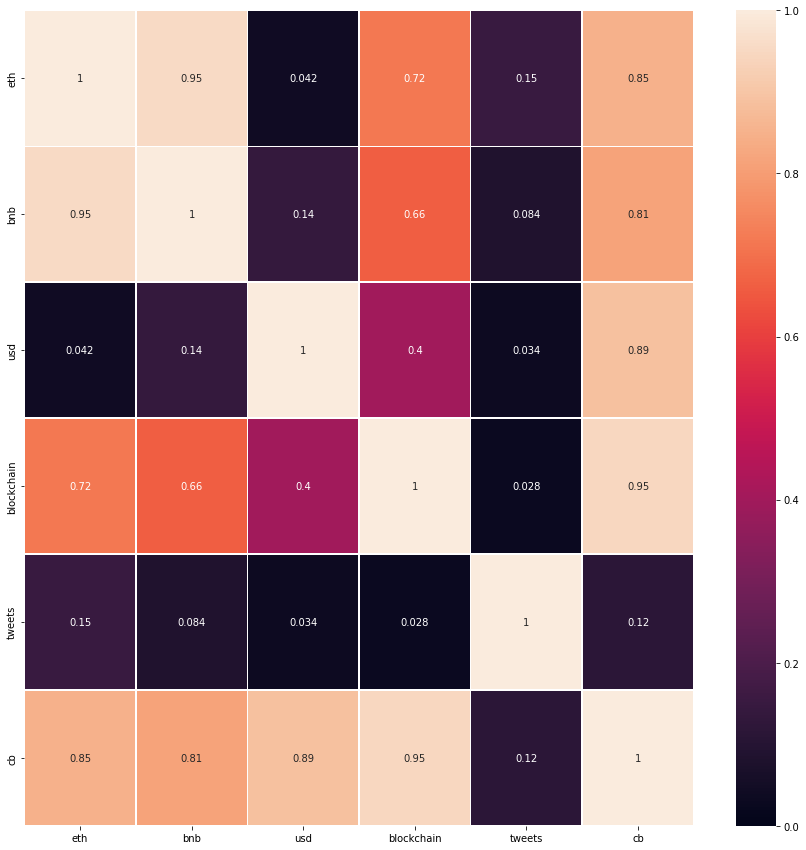

In [ ]:
cont_features = df_og[['eth', 'bnb', 'usd', 'blockchain', 'tweets', 'cb']]
corr_mat = cont_features.corr().abs()
top = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(np.bool))

#Plotting the correlation matrix 
plt.figure(figsize=(15,15))
sns.heatmap(corr_mat, annot= True, vmin= 0, linewidth=0.5)

# Finding features with correlation greater than 0.80
to_drop = [feature for feature in top.columns if any(top[feature] >= 0.80)]
print(to_drop)


## Models

### ARIMA

In [ ]:
df_arima = df_og.copy()
df_arima = df_arima[['btc', 'eth', 'blockchain']]

#### VARMAX model

Since we have exogenous variables, we decide to use VARMAX model at first. The VARMAX procedure enables us to model the dynamic relationship both between the dependent variables and also between the dependent and independent variables. 

Test the stationarity

In [ ]:
from statsmodels.tsa.stattools import adfuller

# ADF Test
result = adfuller((df_arima['btc'] - df_arima['btc'].shift())[1:], autolag='AIC')

print('ADF Statistic: %f' % result[0])

print('p-value: %f' % result[1])

print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -6.293243
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Reject Ho - Time Series is Stationary


stationarize data by differencing

In [ ]:
btc_diff = (df_arima['btc'] - df_arima['btc'].shift())[1:]
eth_diff = (df_arima['eth'] - df_arima['eth'].shift())[1:]
bc_diff = (df_arima['blockchain'] - df_arima['blockchain'].shift())[1:]
df_diff = pd.DataFrame(np.array([btc_diff,eth_diff, bc_diff]).T).rename(columns = {0:'btc', 1:'eth', 2:'bc'})

Split the data into train and test

In [ ]:
split_point = int(len(df_arima)*0.8)
df_dev = df_arima.iloc[:split_point,:]
df_test = df_arima.iloc[split_point:,:]
df_diff_dev = df_diff.iloc[:split_point,:]
df_diff_test = df_diff.iloc[split_point:,:]

Tune the hyperparameters with auto-Arima

In [ ]:
arima_model_btconly = auto_arima(df_diff['btc'], start_p=1, start_q=1, start_P=1, start_Q=1,
                     max_p=5, max_q=5, max_P=5, max_Q=5, seasonal=False,
                     stepwise=True, suppress_warnings=True, D=10, max_D=10,
                     error_action='ignore')
arima_model_btconly.get_params()['order']

(0, 0, 0)

In [ ]:
# VARMAX (0,0) cannot be run as at least one parameter should be bigger than 0. 

# model_1 = VARMAX(df_diff_dev, order = (0,0))
# res_1 = model_1.fit()
# print(res_1.mse)

In [ ]:
arima_model_ethonly = auto_arima(df_diff['eth'], start_p=1, start_q=1, start_P=1, start_Q=1,
                     max_p=5, max_q=5, max_P=5, max_Q=5, seasonal=False,
                     stepwise=True, suppress_warnings=True, D=10, max_D=10,
                     error_action='ignore')
arima_model_ethonly.get_params()['order']

(2, 0, 2)

In [ ]:
model_2 = VARMAX(df_diff_dev, order = (2,2))
res_2 = model_2.fit()
print(res_2.mse)

1334486.085143387


In [ ]:
arima_model_usdonly = auto_arima(df_diff['bc'], start_p=1, start_q=1, start_P=1, start_Q=1,
                     max_p=10, max_q=10, max_P=10, max_Q=10, seasonal=False,
                     stepwise=True, suppress_warnings=True, D=10, max_D=10,
                     error_action='ignore')
arima_model_usdonly.get_params()['order']

(7, 0, 6)

In [ ]:
model_3 = VARMAX(df_diff_dev, order = (7,6))
res_3 = model_3.fit()
print(res_3.mse)

1234113.883283453


VARMAX(7,6) has the best performance. Do the forcasting day by day.

In [ ]:
# Setup forecasts
nforecasts = 1
forecasts = {}

# Get the number of initial training observations
nobs = len(df_diff)
n_init_training = len(df_diff_dev)

# # Create model for initial training sample, fit parameters
init_training_endog = df_diff.iloc[:n_init_training]
mod = VARMAX(df_diff_dev, order=(7,6))
res = mod.fit()

# Save initial forecast
forecasts[df_diff_dev.index[-1]] = res.forecast(steps=nforecasts)

# Step through the rest of the sample
for t in range(n_init_training, nobs):
    # Update the results by appending the next observation
    updated_endog = df_diff.iloc[t:t+1]
    res = res.append(updated_endog, refit=False)

    # Save the new set of forecasts
    forecasts[updated_endog.index[0]] = res.forecast(steps=nforecasts)

Show the forcasting result.

In [ ]:
df_new = df_dev[['btc']].join(pd.concat(forecasts, axis=0).reset_index().drop(columns = 'level_0')[['level_1', 'btc']].set_index('level_1'), rsuffix='diffforecast', how='outer')
df_new.loc[split_point-1,'btcdiffforecast'] = df_new.loc[split_point-1,'btc']
df_new['cumsum'] = df_new['btcdiffforecast'].cumsum()
df_new.fillna(0, inplace=True)
df_varmaxpred = pd.DataFrame(df_new['btc'] + df_new['cumsum'])
df_varmaxpred.iloc[split_point-1,0] = df_varmaxpred.iloc[split_point-1,0]/2


In [ ]:
mean_squared_error(df_test['btc'], df_varmaxpred[split_point:], squared=False)

32152.868512015353

We can see that the prediction results of VARMAX model in the test data are very poor, which even got an opposite trend to the actual values. We consider that if there are too many external interference factors added to the model. In this case, we try to predict with the simplest ARIMA model and only rely on past Bitcion price.

#### ARIMA model

Here we still use auto-Arima to get the best hyperparameters.

In [ ]:
arima_model_btc = auto_arima(df_dev['btc'], start_p=1, start_q=1, start_P=1, start_Q=1,
                     max_p=5, max_q=5, max_P=5, max_Q=5, seasonal=False,
                     stepwise=True, suppress_warnings=True, D=10, max_D=10,
                     error_action='ignore')

In [ ]:
arima_model_btc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1019
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -8632.471
Date:                Mon, 05 Dec 2022   AIC                          17266.943
Time:                        06:58:09   BIC                          17271.868
Sample:                             0   HQIC                         17268.813
                               - 1019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.357e+06   2.49e+04     54.498      0.000    1.31e+06    1.41e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.79   Jarque-Bera (JB):              3992.34
Prob(Q):                              0.38   Prob(JB):                         0.00
Heteroskedasticity (H):              13.12   Skew:                            -0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Forcast day by day.

In [ ]:
# Setup forecasts
nforecasts = 1
forecasts = {}

# Get the number of initial training observations
nobs = len(df_arima)
n_init_training = len(df_dev)

# # Create model for initial training sample, fit parameters
init_training_endog = df_arima['btc'].iloc[:n_init_training]
mod = ARIMA(df_dev['btc'], order=(0,1,0))
res = mod.fit()

# Save initial forecast
forecasts[df_dev['btc'].index[-1]] = res.forecast(steps=nforecasts)

# Step through the rest of the sample
for t in range(n_init_training, nobs):
    # Update the results by appending the next observation
    updated_endog = df_arima['btc'].iloc[t:t+1]
    res = res.append(updated_endog, refit=False)

    # Save the new set of forecasts
    forecasts[updated_endog.index[0]] = res.forecast(steps=nforecasts)


In [ ]:
btc_arima = pd.concat([df_dev['btc'], pd.DataFrame(pd.concat(forecasts, axis=0)).reset_index().drop(columns = 'level_0').set_index('level_1')])

In [ ]:
mean_squared_error(df_test['btc'], btc_arima[split_point:-1], squared=False)

1332.2460057782291

### XGBoost

As we are using XGBoost to train a time series model, we need to manipulate the dataset. First thing to do is adding a time difference column compared to the first day of the dataset(time_diff), because XGBoost doesn't automatically consider the time. Then, since we are predicting the next day's price of Bitcoin, our dataset should be the previous day's dataset including 'bnb', 'eth', 'btc', 'usd', 'blockchain', 'tweets', 'cb', and adding another today's Bitcoin price column(btc_today). After the feature selection, we will keep the X features as: ['eth', 'btc', 'time_diff', 'blockchain'], and the Y feature as 'btc_today'.
 
For the time series dataset, we will split the train test dataset in 0.8:0.2 based on the time. Then we scale the dataset using MinMax scale, following with the fit and transform of the data. We are using XGBRegressor because the target variables are continuous numbers. For tuning the hyperparameters, we are tuning 'max_leaves', 'n_estimators', 'subsample', and 'max_depth'.

In [ ]:
df_xgb = df_og.copy()
df_xgb['time_diff'] = range(0, len(df_xgb))
df_xgb['btc_today'] = df_xgb['btc'].shift(-1)
df_xgb = df_xgb[:-1]

In [ ]:
df_xgb_X = df_xgb[['eth','btc', 'time_diff', 'blockchain']]
df_xgb_y = df_xgb['btc_today']

In [ ]:
dev_X_xgb = df_xgb_X[:int(len(df_xgb_X)*0.8)]
test_X_xgb = df_xgb_X[int(len(df_xgb_X)*0.8):]
dev_y_xgb = df_xgb_y[:int(len(df_xgb_y)*0.8)]
test_y_xgb = df_xgb_y[int(len(df_xgb_y)*0.8):]

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))

dev_X_transformed_xgb = scaler.fit_transform(dev_X_xgb)
test_X_transformed_xgb = scaler.transform(test_X_xgb)

In [ ]:
# XGB

param_grid_xgb = {
                'max_leaves': [1, 3, 5, 7],
                'n_estimators': [100, 300, 500], 
                'subsample': [0.5, 0.7, 1],
                'max_depth': [2, 4, 6],
             }

xgb_svm = XGBRegressor(random_state=100, objective ='reg:squarederror')

grid_clf_xgb = GridSearchCV(xgb_svm, param_grid_xgb, cv=10)
grid_clf_xgb.fit(dev_X_transformed_xgb, dev_y_xgb)

y_pred_xgb = grid_clf_xgb.predict(test_X_transformed_xgb)

print('estimator:', grid_clf_xgb.best_estimator_)
print('params:', grid_clf_xgb.best_params_)

rmse_xgb = mean_squared_error(test_y_xgb, y_pred_xgb, squared=False)
print(rmse_xgb)
mape_xgb = mean_absolute_percentage_error(test_y_xgb, y_pred_xgb)
print(mape_xgb)

estimator: XGBRegressor(max_depth=2, max_leaves=1, objective='reg:squarederror',
             random_state=100, subsample=0.7)
params: {'max_depth': 2, 'max_leaves': 1, 'n_estimators': 100, 'subsample': 0.7}
2994.6619546328834
0.10622799995250949


###  LSTM

For the LSTM model, we use two layers of LSTM. The input layer depends on the input size of the feature vector. If we use 30 day time series data and 3 features, it would be a (30, 3) vector input.

For the activation layer, we use the Sigmoid function. Since we will predict a positive value in the previous (min, max) range, so we have to map the output value to a (0, 1) range. The Sigmoid function is such a function that could deal with this case.

The model is trained as followed:

![](https://drive.google.com/uc?export=view&id=)

![](https://drive.google.com/uc?export=view&id=11vRXWf_eYWFoynZuV1wzBuH22rqbAVog)

<img src=''>

In [ ]:
def get_model(input_size, num_features):
    model = keras.Sequential()
    model.add(layers.LSTM(100, return_sequences=True, input_shape=(input_size, num_features)))
    model.add(layers.LSTM(100, return_sequences=False))
    model.add(layers.Dense(25))
    model.add(layers.Dense(1, activation=activations.sigmoid))
    return model

In [ ]:
def train_model(dataset_origin, time_seq_len, epochs):
    x_train, y_train, x_test, y_test, btc_scaler = prepare_dataset_for_lstm(dataset_origin, time_seq_len, 0.8)
    model = get_model(x_train.shape[1], 3)
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    history_callback = model.fit(x_train, y_train, batch_size= 1, epochs=epochs)

    predictions = model.predict(x_test)
    predictions = btc_scaler.inverse_transform(predictions)
    rmse = np.sqrt(np.mean(predictions - y_test)**2)
    return model, history_callback, predictions, rmse

In [ ]:
model_30d, history_callback_30d, predictions_30d, rmse_30d = train_model(df_og, 30, 20)
print(model_30d.summary())
print(rmse_30d)

Epoch 1/20
990/990 [==============================] - 22s 19ms/step - loss: 0.0643
Epoch 2/20
990/990 [==============================] - 20s 20ms/step - loss: 0.0087
Epoch 3/20
990/990 [==============================] - 19s 19ms/step - loss: 0.0072
Epoch 4/20
990/990 [==============================] - 19s 19ms/step - loss: 0.0066
Epoch 5/20
990/990 [==============================] - 19s 19ms/step - loss: 0.0070
Epoch 6/20
990/990 [==============================] - 19s 20ms/step - loss: 0.0066
Epoch 7/20
990/990 [==============================] - 19s 19ms/step - loss: 0.0069
Epoch 8/20
990/990 [==============================] - 19s 20ms/step - loss: 0.0154
Epoch 9/20
990/990 [==============================] - 19s 19ms/step - loss: 0.0067
Epoch 10/20
990/990 [==============================] - 18s 19ms/step - loss: 0.0063
Epoch 11/20
990/990 [==============================] - 19s 19ms/step - loss: 0.0067
Epoch 12/20
990/990 [==============================] - 19s 19ms/step - loss: 0.0061
E

In [ ]:
model_45d, history_callback_45d, predictions_45d, rmse_45d = train_model(df_og, 45, 20)
print(model_45d.summary())
print(rmse_45d)

Epoch 1/20
975/975 [==============================] - 30s 28ms/step - loss: 0.0401
Epoch 2/20
975/975 [==============================] - 27s 28ms/step - loss: 0.0098
Epoch 3/20
975/975 [==============================] - 27s 28ms/step - loss: 0.0277
Epoch 4/20
975/975 [==============================] - 27s 28ms/step - loss: 0.0125
Epoch 5/20
975/975 [==============================] - 27s 27ms/step - loss: 0.0098
Epoch 6/20
975/975 [==============================] - 27s 27ms/step - loss: 0.0077
Epoch 7/20
975/975 [==============================] - 27s 28ms/step - loss: 0.0098
Epoch 8/20
975/975 [==============================] - 27s 28ms/step - loss: 0.0155
Epoch 9/20
975/975 [==============================] - 28s 29ms/step - loss: 0.0078
Epoch 10/20
975/975 [==============================] - 27s 28ms/step - loss: 0.0064
Epoch 11/20
975/975 [==============================] - 27s 28ms/step - loss: 0.0064
Epoch 12/20
975/975 [==============================] - 27s 28ms/step - loss: 0.0069
E

In [ ]:
model_60d, history_callback_60d, predictions_60d, rmse_60d = train_model(df_og, 60, 20)
print(model_60d.summary())
print(rmse_60d)

Epoch 1/20
960/960 [==============================] - 35s 34ms/step - loss: 0.0561
Epoch 2/20
960/960 [==============================] - 32s 34ms/step - loss: 0.0500
Epoch 3/20
960/960 [==============================] - 32s 33ms/step - loss: 0.0132
Epoch 4/20
960/960 [==============================] - 34s 35ms/step - loss: 0.0097
Epoch 5/20
960/960 [==============================] - 32s 34ms/step - loss: 0.0088
Epoch 6/20
960/960 [==============================] - 32s 34ms/step - loss: 0.0093
Epoch 7/20
960/960 [==============================] - 32s 34ms/step - loss: 0.0067
Epoch 8/20
960/960 [==============================] - 32s 34ms/step - loss: 0.0093
Epoch 9/20
960/960 [==============================] - 32s 34ms/step - loss: 0.0070
Epoch 10/20
960/960 [==============================] - 32s 34ms/step - loss: 0.0063
Epoch 11/20
960/960 [==============================] - 34s 35ms/step - loss: 0.0062
Epoch 12/20
960/960 [==============================] - 32s 34ms/step - loss: 0.0083
E

## Evaluation

### ARIMA

VARMAX

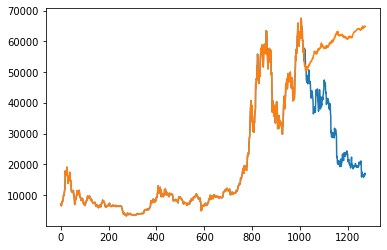

In [ ]:
plt.plot(df_arima['btc'])
plt.plot(df_varmaxpred)

In [ ]:
mean_squared_error(df_test['btc'], df_varmaxpred[split_point:], squared=False)

32152.868512015353

simple ARIMA

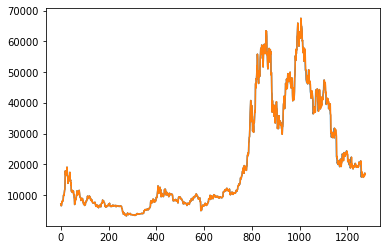

In [ ]:
plt.plot(df_arima['btc'])
plt.plot(btc_arima)

In [ ]:
mean_squared_error(df_test['btc'], btc_arima[split_point:-1], squared=False)

1332.2460057782291

In the VARMAX model, we used yesterday's price to predict tomorrow's price. But this model considered many extraneoous factors which influenced this model to cause a negative trend with the actual trend. But in the simple ARIMA model, it still used one day's price to predict another day. Although it gives a strong predicting performance, this model gives tiny actual reference values due to the data selection.

### XGBoost

In [ ]:
rmse_xgb = mean_squared_error(test_y_xgb, y_pred_xgb, squared=False)
print(rmse_xgb)
mape_xgb = mean_absolute_percentage_error(test_y_xgb, y_pred_xgb)
print(mape_xgb)

2994.6619546328834
0.10622799995250949


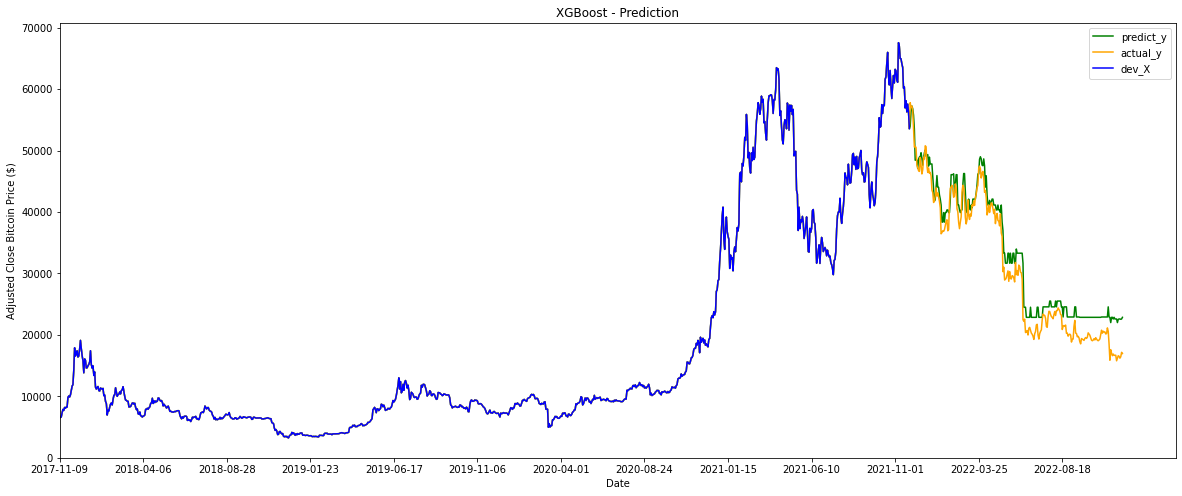

In [ ]:
l_b = int(len(df_xgb_X)*0.8)
r_b = len(df_xgb_X)
a_list = list(range(l_b, r_b))

f, ax = plt.subplots(1, figsize=(20, 8))
plt.plot(df_xgb['Date'], np.concatenate((dev_y_xgb.values, y_pred_xgb)), label = 'predict_y', color = 'green')
plt.plot(df_xgb['Date'], dev_y_xgb.append(test_y_xgb), label = 'actual_y', color = 'orange')
ax.plot(df_xgb['Date'][:1018], dev_y_xgb, label = 'dev_X', color = 'blue')
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)
ax.set_xlabel('Date')
ax.set_ylabel('Adjusted Close Bitcoin Price ($)')
ax.set_xticks(ax.get_xticks()[::100])
plt.legend()
plt.title('XGBoost - Prediction')
plt.show()

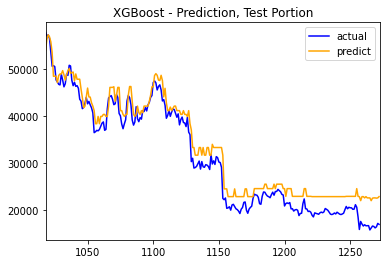

In [ ]:
l_b = int(len(df_xgb_X)*0.8)
r_b = len(df_xgb_X)
a_list = list(range(l_b, r_b))

plt.plot(a_list, test_y_xgb, label = 'actual', color = 'blue')
plt.plot(a_list, y_pred_xgb, label = 'predict', color = 'orange')
ax.set_xlabel('Date')
ax.set_ylabel('Adjusted Close Bitcoin Price ($)')
plt.title('XGBoost - Prediction, Test Portion')
plt.xlim([l_b, r_b])
plt.legend()
plt.show()

In the XGBoost model, the RMSE is 2995. We used one-day-before price to predict the future price. And prediction meets all the tendency of changed of actual values. Also, prediction almost fits the actual value accurately until 2022-05. It gives a strong performance on predicting the price value, but it also would have data issues due to selecting of one-day-before data to predict.

### LSTM

For the training loss, we use 20 epochs to train the LSTM model, and the loss decreases in epochs with some fluctuation. The 45day performs best in these three selected time length.

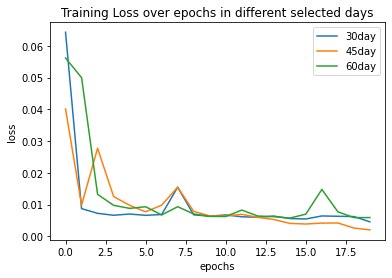

In [ ]:
hist_30d = pd.DataFrame(history_callback_30d.history)
hist_45d = pd.DataFrame(history_callback_45d.history)
hist_60d = pd.DataFrame(history_callback_60d.history) 
fig, ax = plt.subplots()
ax.plot(hist_30d.index, hist_30d["loss"], label="30day")
ax.plot(hist_45d.index, hist_45d["loss"], label="45day") 
ax.plot(hist_60d.index, hist_60d["loss"], label="60day")
ax.legend()
ax.set_ylabel("loss") 
ax.set_xlabel("epochs")
ax.set_title("Training Loss over epochs in different selected days")
plt.show()


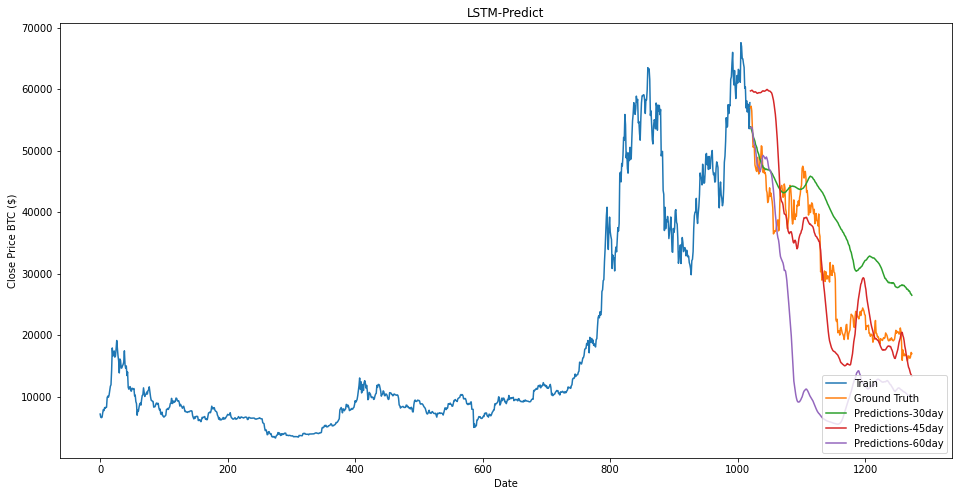

In [ ]:
data = df_og.filter(['btc'])
training_data_len = math.ceil(len(data)* 0.8)
train = data[:training_data_len]
gt = data[training_data_len:]
gt['Predictions-30d'] = predictions_30d
gt['Predictions-45d'] = predictions_45d
gt['Predictions-60d'] = predictions_60d
plt.figure(figsize=(16,8))
plt.title('LSTM-Predict')
plt.xlabel('Date')
plt.ylabel('Close Price BTC ($)')
plt.plot(train)
plt.plot(gt[['btc', 'Predictions-30d', 'Predictions-45d', 'Predictions-60d']])
plt.legend(['Train', 'Ground Truth', 'Predictions-30day', 'Predictions-45day', 'Predictions-60day'], loc='lower right')
plt.show()

For the predicting results, the 45-day performs best in predicting the price as well as the trend. In the test set, it successfully predict the decr-incr-decr-incr-decr-incr-decr-incr-decr-incr-decr sequence which includes six ascending and five descending. It is similar to the actual trend of the BTC. 

For 30day, it predicts the better overall decreasing trend, but it lose a lot of small period fluctuations. It only contains three descending and two ascending. For 60day, it predict the similar trends but have a larger diff with the actual price. This might be caused by which the training data is not long enough. The longer input sequence would require more data to get a better performance.

Considering the RMSE which is a measure of how spread out these residuals are, the 45days prediction gives 165, the 60days prediction gives 12693, and the 30days prediction gives 7502. We can clearly tell the 45days prediction fits better.

## Conclusion

For this project, we exploring three different models on predicting the future BTC price and trends: ARIMA/VARMAX, XGBoost and LSTM. We compare them by the RMSE loss with the actual price, and also the trends they predict vs the actual trend.

The LSTM performs best in this selected dataset and features. It gets the lowest RMSE and the most accurate trend prediction in the time series data. For the selected time length, the 45-day performs best because it is not too short for including enough details. Additionally, it also fits into this dataset. If we want to choose longer period, more data is required.

Though the data we predict is closed to actual data, it could not be applied to do the BTC transaction directly. We still have a lot of work to do. First, now the model could only predict the next price according to the past x day prices, while the ideal case is that we could predict another sequence like future y-day price. Second, we do not include many features, features like USD and related stock price should be better pre-processed to fit into the model. And we need to explore more features from social media like tweets to consider the attitude to the BTC. Third, we should consider more complicated model to get a better performance with more features.

During our project, we learn a lot about machine learning techniques applied to predict time series data. We are happy to see its ability to predict the price and trends of BTC. We hope we could get a better model in the future to help our investment!

## References

Vidal R D-n (2014) The fractal nature of Bitcoin: evidence from wavelet power spectra. In: Pinto A, Accinelli GE, Yannacopoulos A, Hervés-Beloso C (eds) (eds)Trends in mathematical economics. Springer, Cham, pp 73–98

Guo Y, Liang C (2016) Blockchain application and outlook in the banking industry. Financ Innov 2(1):24

Dataset: 

Bitcoin prices: https://finance.yahoo.com/quote/BTC-USD/history?p=BTC-USD

US Dollar Index: https://finance.yahoo.com/quote/DX-Y.NYB/history?p=DX-Y.NYB

Relevant tweets from twitter: https://www.kaggle.com/datasets/kaushiksuresh147/bitcoin-tweets

Past ETH prices: https://finance.yahoo.com/quote/ETH-USD/history?p=ETH-USD

Past BNB prices: https://finance.yahoo.com/quote/BNB-USD/history?p=BNB-USD

Past Coinbase prices: https://finance.yahoo.com/quote/COIN/history?p=COIN
        
Past RIOT Blockchain Prices: https://finance.yahoo.com/quote/RIOT/history?p=RIOT